In [65]:
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet
from prophet.plot import plot_forecast_component, plot_yearly, plot_weekly, plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objs as go

In [66]:
acled = pd.read_json('acled.json')

In [67]:
india_acled = acled[acled['COUNTRY'] == 'India']

In [68]:
india_acled['EVENT_DATE'] = pd.to_datetime(india_acled['EVENT_DATE'].astype(str), format='%Y%m%d')

/tmp/ipykernel_25656/271134095.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
india_demonstrations = india_acled[(india_acled['EVENT_TYPE'] == 'Protests') | (india_acled['EVENT_TYPE'] == 'Riots')]

In [70]:
india_demonstration_count = india_demonstrations.groupby(pd.Grouper(key = 'EVENT_DATE', freq = 'D')).count()
india_demonstration_count = india_demonstration_count[['ACTOR1']]
india_demonstration_count = india_demonstration_count.reset_index()
india_demonstration_count.columns = ['ds','y']
india_demonstration_count.head()

ds   y
0 2016-01-01  15
1 2016-01-02  21
2 2016-01-03  17
3 2016-01-04  29
4 2016-01-05  33

In [71]:
india_demonstration_count.tail()

ds   y
1754 2020-10-20  48
1755 2020-10-21  41
1756 2020-10-22  24
1757 2020-10-23  26
1758 2020-10-24  11

In [72]:
india_demonstration_count.loc[(india_demonstration_count['y'] > 150), 'y']

822     273
983     325
1103    269
1130    166
1141    173
1196    204
1729    253
1732    154
1739    187
Name: y, dtype: int64

In [73]:
india_demonstration_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1759 non-null   datetime64[ns]
 1   y       1759 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 27.6 KB


In [74]:
india_demonstration_count.loc[(india_demonstration_count['y'] > 150), 'y'] = None # Why set to null?


In [75]:
india_demonstration_count.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1759 non-null   datetime64[ns]
 1   y       1750 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.6 KB


In [76]:
m_india = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality = False).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 15)
m_india.add_country_holidays(country_name = 'IN')
model_india = m_india.fit(india_demonstration_count)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -51.7243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2818.42     0.0461167       190.383           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2823.37    0.00347603       80.6748       0.538       0.538      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2823.71   0.000255579       85.2399   3.456e-06       0.001      334  LS failed, Hessian reset 
     272       2823.72   1.10206e-06       75.2017    1.39e-08       0.001      420  LS failed, Hessian reset 
     280       2823.72   8.97228e-08       60.2038      0.1774        0.85      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [77]:
future_india = m_india.make_future_dataframe(periods = 300, freq = 'D')
forecast_india = m_india.predict(future_india)
forecast_india.tail()

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2054 2021-08-16  29.026317   15.662788   61.441053    25.071428    32.943066   
2055 2021-08-17  28.991116    8.934078   54.164716    25.018721    32.933397   
2056 2021-08-18  28.955916    8.821622   56.381793    24.966014    32.923884   
2057 2021-08-19  28.920716    0.127218   46.742313    24.913306    32.905439   
2058 2021-08-20  28.885516    9.370140   54.496559    24.860599    32.892599   

      All Saints Day  All Saints Day_lower  All Saints Day_upper  \
2054             0.0                   0.0                   0.0   
2055             0.0                   0.0                   0.0   
2056             0.0                   0.0                   0.0   
2057             0.0                   0.0                   0.0   
2058             0.0                   0.0                   0.0   

      All Souls Day  ...    weekly  weekly_lower  weekly_upper    yearly  \
2054            0.0  ...  0.272126      0.272126      0.272126  0.034895   
2055            0.0  ...  0.071912      0.071912      0.071912  0.034372   
2056            0.0  ...  0.090805      0.090805      0.090805  0.035511   
2057            0.0  ... -0.030415     -0.030415     -0.030415  0.038465   
2058            0.0  ...  0.056513      0.056513      0.056513  0.043329   

      yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
2054      0.034895      0.034895             0.0                   0.0   
2055      0.034372      0.034372             0.0                   0.0   
2056      0.035511      0.035511             0.0                   0.0   
2057      0.038465      0.038465             0.0                   0.0   
2058      0.043329      0.043329             0.0                   0.0   

      additive_terms_upper       yhat  
2054                   0.0  37.937995  
2055                   0.0  32.072432  
2056                   0.0  32.613516  
2057                   0.0  23.994845  
2058                   0.0  31.769512  

[5 rows x 88 columns]

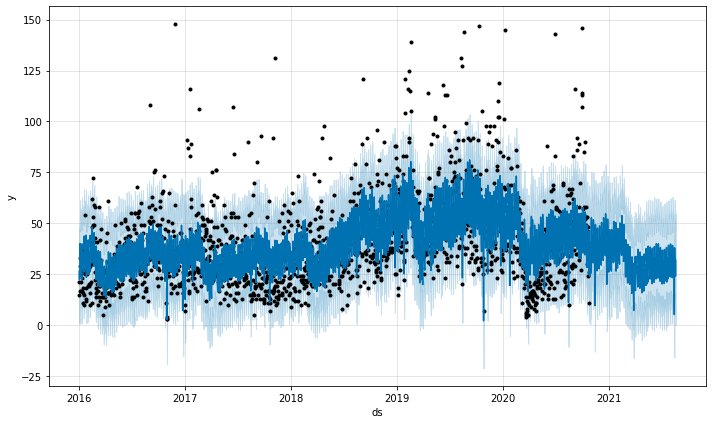

In [78]:
demonstration_plot_india = m_india.plot(forecast_india)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



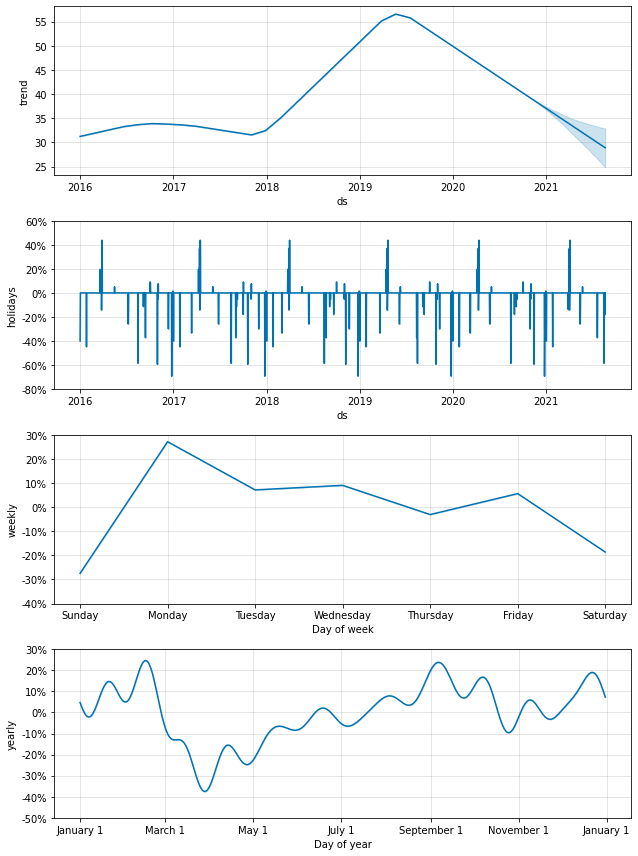

In [79]:
demonstration_components_india = m_india.plot_components(forecast_india) 

In [80]:
plot_components_plotly(m_india, forecast_india)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [81]:
# plot_forecast_component(m_india_hol, forecast_india_hol, 'Christmas Day')
# plt.title('Christmas Day Impact on India')
# plt.show()

In [82]:
demonstration_cv_india = cross_validation(m_india, initial='1000 days', period='180 days', horizon = '365 days')
demonstration_cv_india.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2018-10-30 00:00:00 and 2019-10-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -10.2655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1877.55     0.0386667       92.8864      0.2686           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1881.49   0.000312914       65.3261      0.0481           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        1881.5   0.000140739       58.4093   2.154e-06       0.001      309  LS failed, Hessian reset 
     293       1882.09    0.00137471       68.9676   2.371e-05       0.001      466  LS failed, Hessian reset 
     299       1882.16    0.00143537       79.2649           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1882.46   9.07008e-05       74.1783     0.03272           1      603   
    Iter      log pro

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -13.7238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2136.11     0.0367127       226.497           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       2140.01   0.000600339       90.6874   7.997e-06       0.001      278  LS failed, Hessian reset 
     199       2140.11   0.000156933       81.0133        0.35        0.35      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        2140.3   2.85994e-05       63.9397    5.29e-07       0.001      430  LS failed, Hessian reset 
     299       2140.31   3.21993e-06       67.5128      0.4381      0.4381      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       2140.33   0.000178427       87.6249   2.647e-06       0.001      536  LS failed, Hessian rese

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -15.8769
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2364.23     0.0137203       84.9571           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2368.36    0.00202519       82.3161      0.5876      0.5876      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       2368.48   0.000186618       70.0862   2.363e-06       0.001      331  LS failed, Hessian reset 
     290       2368.55   0.000101673       64.3983   1.185e-06       0.001      448  LS failed, Hessian reset 
     299       2368.56   1.23965e-05       64.1743      0.3122      0.3122      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       2368.58   5.79139e-08       53.4505       0.176       0.176      602   
Optimization terminat

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2018-10-31  48.605939   29.235832   66.681790  46.0 2018-10-30
1 2018-11-01  33.006986   14.139728   50.396132  52.0 2018-10-30
2 2018-11-02  39.682662   22.656833   59.593020  81.0 2018-10-30
3 2018-11-03  33.855760   16.401850   52.908723  40.0 2018-10-30
4 2018-11-04  28.244901   11.248779   46.516720  26.0 2018-10-30

In [83]:
demonstration_india = performance_metrics(demonstration_cv_india)
demonstration_india.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 36 days  401.197613  20.029918  15.767274  0.329033  0.245897  0.304990   
1 37 days  392.296237  19.806470  15.473140  0.321598  0.228043  0.299021   
2 38 days  389.512370  19.736068  15.359544  0.318171  0.217029  0.294585   
3 39 days  366.438781  19.142591  14.696999  0.306567  0.211517  0.283263   
4 40 days  374.310179  19.347097  14.896005  0.311478  0.213199  0.286847   

   coverage  
0  0.694444  
1  0.703704  
2  0.712963  
3  0.731481  
4  0.722222

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



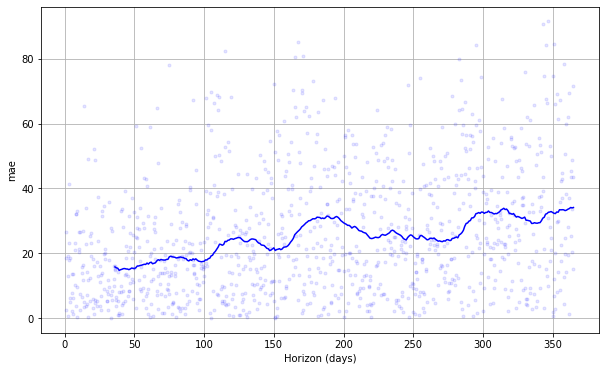

In [84]:
fig = plot_cross_validation_metric(demonstration_cv_india, metric='mae')

In [85]:
forecast_india

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2016-01-01  31.243658    0.988097   44.900214    31.243658    31.243658   
1    2016-01-02  31.255613    3.505001   48.211427    31.255613    31.255613   
2    2016-01-03  31.267569    0.683538   46.072095    31.267569    31.267569   
3    2016-01-04  31.279524   18.395283   61.290238    31.279524    31.279524   
4    2016-01-05  31.291479   11.317642   55.526451    31.291479    31.291479   
...         ...        ...         ...         ...          ...          ...   
2054 2021-08-16  29.026317   15.662788   61.441053    25.071428    32.943066   
2055 2021-08-17  28.991116    8.934078   54.164716    25.018721    32.933397   
2056 2021-08-18  28.955916    8.821622   56.381793    24.966014    32.923884   
2057 2021-08-19  28.920716    0.127218   46.742313    24.913306    32.905439   
2058 2021-08-20  28.885516    9.370140   54.496559    24.860599    32.892599   

      All Saints Day  All Saints Day_lower  All Saints Day_upper  \
0                0.0                   0.0                   0.0   
1                0.0                   0.0                   0.0   
2                0.0                   0.0                   0.0   
3                0.0                   0.0                   0.0   
4                0.0                   0.0                   0.0   
...              ...                   ...                   ...   
2054             0.0                   0.0                   0.0   
2055             0.0                   0.0                   0.0   
2056             0.0                   0.0                   0.0   
2057             0.0                   0.0                   0.0   
2058             0.0                   0.0                   0.0   

      All Souls Day  ...    weekly  weekly_lower  weekly_upper    yearly  \
0               0.0  ...  0.056513      0.056513      0.056513  0.062688   
1               0.0  ... -0.186231     -0.186231     -0.186231  0.042577   
2               0.0  ... -0.274710     -0.274710     -0.274710  0.024011   
3               0.0  ...  0.272126      0.272126      0.272126  0.007790   
4               0.0  ...  0.071912      0.071912      0.071912 -0.005373   
...             ...  ...       ...           ...           ...       ...   
2054            0.0  ...  0.272126      0.272126      0.272126  0.034895   
2055            0.0  ...  0.071912      0.071912      0.071912  0.034372   
2056            0.0  ...  0.090805      0.090805      0.090805  0.035511   
2057            0.0  ... -0.030415     -0.030415     -0.030415  0.038465   
2058            0.0  ...  0.056513      0.056513      0.056513  0.043329   

      yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0         0.062688      0.062688             0.0                   0.0   
1         0.042577      0.042577             0.0                   0.0   
2         0.024011      0.024011             0.0                   0.0   
3         0.007790      0.007790             0.0                   0.0   
4        -0.005373     -0.005373             0.0                   0.0   
...            ...           ...             ...                   ...   
2054      0.034895      0.034895             0.0                   0.0   
2055      0.034372      0.034372             0.0                   0.0   
2056      0.035511      0.035511             0.0                   0.0   
2057      0.038465      0.038465             0.0                   0.0   
2058      0.043329      0.043329             0.0                   0.0   

      additive_terms_upper       yhat  
0                      0.0  22.479373  
1                      0.0  26.765623  
2                      0.0  23.428809  
3                      0.0  40.035173  
4                      0.0  33.373597  
...                    ...        ...  
2054                   0.0  37.937995  
2055                   0.0  32.072432  
2056                   0.0  32.613516  
2057                   0.0  23.99

In [86]:
demonstrations_eval = pd.concat([forecast_india['yhat'], forecast_india['ds']], axis = 1)
demonstrations_eval = demonstrations_eval.merge(india_demonstration_count, on = 'ds')
demonstrations_eval.index = demonstrations_eval['ds']
demonstrations_eval = demonstrations_eval.drop(columns = 'ds')
demonstrations_eval.columns = ['prophet', 'truth']
demonstrations_eval.tail()

prophet  truth
ds                          
2020-10-20  40.394686   48.0
2020-10-21  40.464050   41.0
2020-10-22  35.129820   24.0
2020-10-23  38.171121   26.0
2020-10-24  28.359822   11.0

In [87]:
demonstrations_eval = demonstrations_eval.fillna(method = 'ffill')


In [88]:
print(f"With holidays:\t{mean_absolute_error(demonstrations_eval['truth'], demonstrations_eval['prophet']):.4f}")


With holidays:	12.7377


In [89]:
# print('MSE comparison ----')
# print(f"Prophet:\t{mean_absolute_error(demonstration_count_india['y'], forecast_india.iloc[:demonstration_count_india.shape[0]]['yhat']):.4f}")
# print(f"With holidays:\t{mean_absolute_error(demonstration_count_india['y'], forecast_india_hol.iloc[:demonstration_count_india.shape[0]]['yhat']):.4f}")

# demonstration_count_india.plot(title='India Demonstration Forecast evaluation', figsize=(12,4));

# Additional Regressor

## Prep dataframes

In [98]:
india = pd.read_json('india-news-headlines_IN_features_extracted.json')

In [107]:
india_demonstration_count.index = india_demonstration_count['ds']

y
ds              
2016-01-01  15.0
2016-01-02  21.0
2016-01-03  17.0
2016-01-04  29.0
2016-01-05  33.0
...          ...
2020-10-20  48.0
2020-10-21  41.0
2020-10-22  24.0
2020-10-23  26.0
2020-10-24  11.0

[1759 rows x 1 columns]

In [113]:
india['total articles'] = 1
india['negative articles'] = india['SA tag'].map({'POSITIVE': 0, 'NEGATIVE': 1})
india['positive articles'] = india['SA tag'].map({'POSITIVE': 1, 'NEGATIVE': 0})
india['date'] = pd.to_datetime(india['date'])
india = india.groupby(['news tag', pd.Grouper(key = 'date', freq = '1D')]).sum()
india['Sentiment Index'] = india['negative articles'] / india['total articles']
india['Sentiment Index'].fillna(0)
india_visualise_world = (pd.merge(india.loc['World'].asfreq('D'), india_demonstration_count.asfreq('D'), left_index=True, right_index=True)).fillna(0).reset_index(drop=True)
india_visualise_business = (pd.merge(india.loc['Business'].asfreq('D'), india_demonstration_count.asfreq('D'), left_index=True, right_index=True)).fillna(0).reset_index(drop=True)
india_visualise_sci = (pd.merge(india.loc['Sci/Tech'].asfreq('D'), india_demonstration_count.asfreq('D'), left_index=True, right_index=True)).fillna(0).reset_index(drop=True)
india_visualise_sports = (pd.merge(india.loc['Sports'].asfreq('D'), india_demonstration_count.asfreq('D'), left_index=True, right_index=True)).fillna(0).reset_index(drop=True)

In [114]:
india_dfs = {
    'World': india_visualise_world,
    'Business' : india_visualise_business,
    'Sci/Tech' : india_visualise_sci,
    'Sports' : india_visualise_sports
}

In [115]:
india_dfs['World']

news tag confidence  SA tag confidence  total articles  \
0               69.040127          71.615958              72   
1               68.304356          73.619873              75   
2               89.600135          95.188165              96   
3               68.591397          72.063326              73   
4               74.486332          80.421574              81   
...                   ...                ...             ...   
1754           109.536014         117.789147             119   
1755           111.520118         122.850160             124   
1756           117.488072         127.928109             129   
1757           109.649621         118.308189             119   
1758           107.917150         117.810973             119   

      negative articles  positive articles  Sentiment Index         ds     y  
0                    34                 38         0.472222 2016-01-01  15.0  
1                    34                 41         0.453333 2016-01-02  21.0  
2                    49                 47         0.510417 2016-01-03  17.0  
3                    43                 30         0.589041 2016-01-04  29.0  
4                    46                 35         0.567901 2016-01-05  33.0  
...                 ...                ...              ...        ...   ...  
1754                 70                 49         0.588235 2020-10-20  48.0  
1755                 72                 52         0.580645 2020-10-21  41.0  
1756                 82                 47         0.635659 2020-10-22  24.0  
1757                 80                 39         0.672269 2020-10-23  26.0  
1758                 72                 47         0.605042 2020-10-24  11.0  

[1759 rows x 8 columns]

## Sentiment Index

In [195]:
m_india_sentiment_index = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality = False).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 15)
m_india_sentiment_index.add_country_holidays(country_name = 'IN')
m_india_sentiment_index.add_regressor('Sentiment Index')

In [196]:
m_india_sentiment_index.fit(india_dfs['World'])
future_india_sentiment_index = m_india_sentiment_index.make_future_dataframe(periods = 300, freq = 'D')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -51.7543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2796.68     0.0138006       105.829           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2803.22     0.0096673       93.3893           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       2803.62   2.43155e-05        63.572   2.783e-07       0.001      383  LS failed, Hessian reset 
     285       2803.63   9.46997e-08       52.2754      0.3287           1      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [197]:
future_india_sentiment_index = pd.merge(future_india_sentiment_index, india_dfs['World'], how = 'left', on= 'ds')

In [198]:
future_india_sentiment_index.tail()

ds  news tag confidence  SA tag confidence  total articles  \
2054 2021-08-16                  NaN                NaN             NaN   
2055 2021-08-17                  NaN                NaN             NaN   
2056 2021-08-18                  NaN                NaN             NaN   
2057 2021-08-19                  NaN                NaN             NaN   
2058 2021-08-20                  NaN                NaN             NaN   

      negative articles  positive articles  Sentiment Index   y  
2054                NaN                NaN              NaN NaN  
2055                NaN                NaN              NaN NaN  
2056                NaN                NaN              NaN NaN  
2057                NaN                NaN              NaN NaN  
2058                NaN                NaN              NaN NaN

In [199]:
future_india_sentiment_index['Sentiment Index'].isnull().sum()

300

In [200]:
future_india_sentiment_index['Sentiment Index'] = future_india_sentiment_index['Sentiment Index'].interpolate(method = 'linear')


In [201]:
future_india_sentiment_index['Sentiment Index'].isnull().sum()

0

In [202]:
forecast_india_sentiment_index = m_india_sentiment_index.predict(future_india_sentiment_index)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



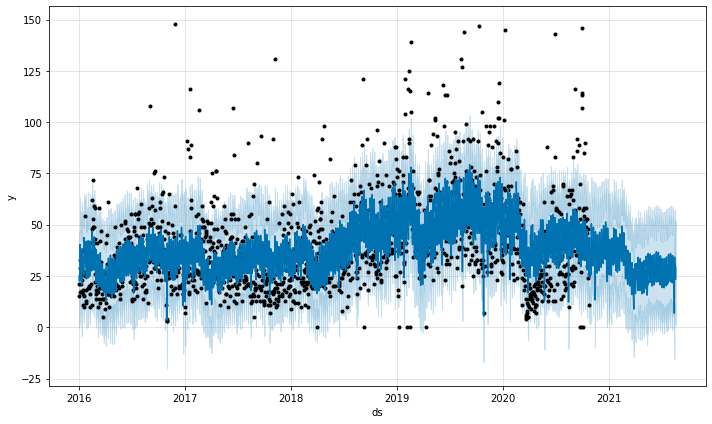

In [203]:
plot_sentiment_index = m_india_sentiment_index.plot(forecast_india_sentiment_index)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



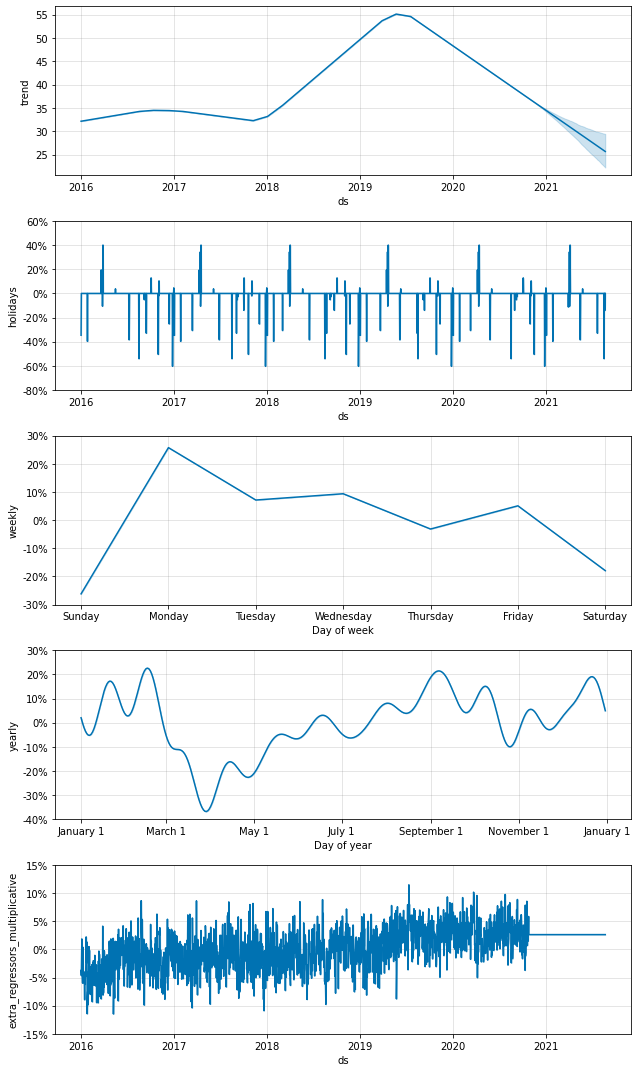

In [204]:
plot_component_sentiment_index = m_india_sentiment_index.plot_components(forecast_india_sentiment_index)


In [205]:
plot_components_plotly(m_india_sentiment_index, forecast_india_sentiment_index)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



## No. of Negative Articles

In [206]:
m_india_negative_articles = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality = False).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 15)
m_india_negative_articles.add_country_holidays(country_name = 'IN')
m_india_negative_articles.add_regressor('negative articles')

In [207]:
m_india_negative_articles.fit(india_dfs['World'])
future_india_negative_articles = m_india_negative_articles.make_future_dataframe(periods = 300, freq = 'D')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -51.7543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2796.38    0.00334625       83.1128           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        2798.9      0.003399       212.959   5.666e-05       0.001      235  LS failed, Hessian reset 
     199       2799.31   5.20564e-05       52.4688           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       2799.35   0.000131148        73.173   2.175e-06       0.001      363  LS failed, Hessian reset 
     299       2799.37    0.00014763       50.5848       1.905      0.4215      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        2799.8   0.000461315       81.1486   5.422e-06       0.001      556  LS failed, Hessian rese

In [208]:
future_india_negative_articles = pd.merge(future_india_negative_articles, india_dfs['World'], how = 'left', on= 'ds')

In [209]:
future_india_negative_articles.tail()

ds  news tag confidence  SA tag confidence  total articles  \
2054 2021-08-16                  NaN                NaN             NaN   
2055 2021-08-17                  NaN                NaN             NaN   
2056 2021-08-18                  NaN                NaN             NaN   
2057 2021-08-19                  NaN                NaN             NaN   
2058 2021-08-20                  NaN                NaN             NaN   

      negative articles  positive articles  Sentiment Index   y  
2054                NaN                NaN              NaN NaN  
2055                NaN                NaN              NaN NaN  
2056                NaN                NaN              NaN NaN  
2057                NaN                NaN              NaN NaN  
2058                NaN                NaN              NaN NaN

In [210]:
future_india_negative_articles['negative articles'].isnull().sum()

300

In [211]:
future_india_negative_articles['negative articles'] = future_india_negative_articles['negative articles'].interpolate(method = 'linear')


In [212]:
future_india_negative_articles['negative articles'].isnull().sum()

0

In [213]:
forecast_india_negative_articles = m_india_negative_articles.predict(future_india_negative_articles)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



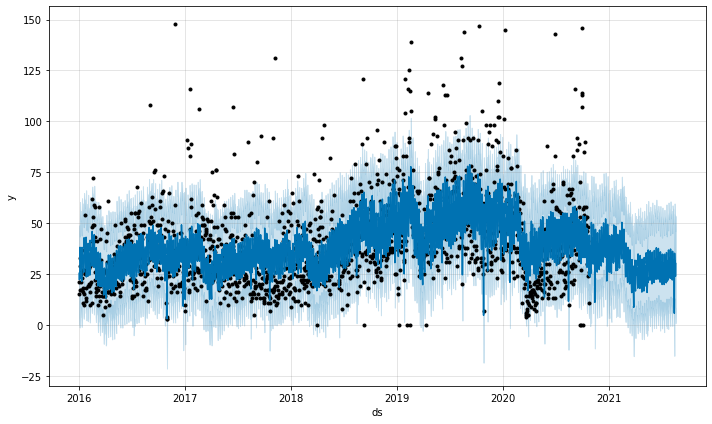

In [214]:
plot_negative_articles = m_india_negative_articles.plot(forecast_india_negative_articles)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



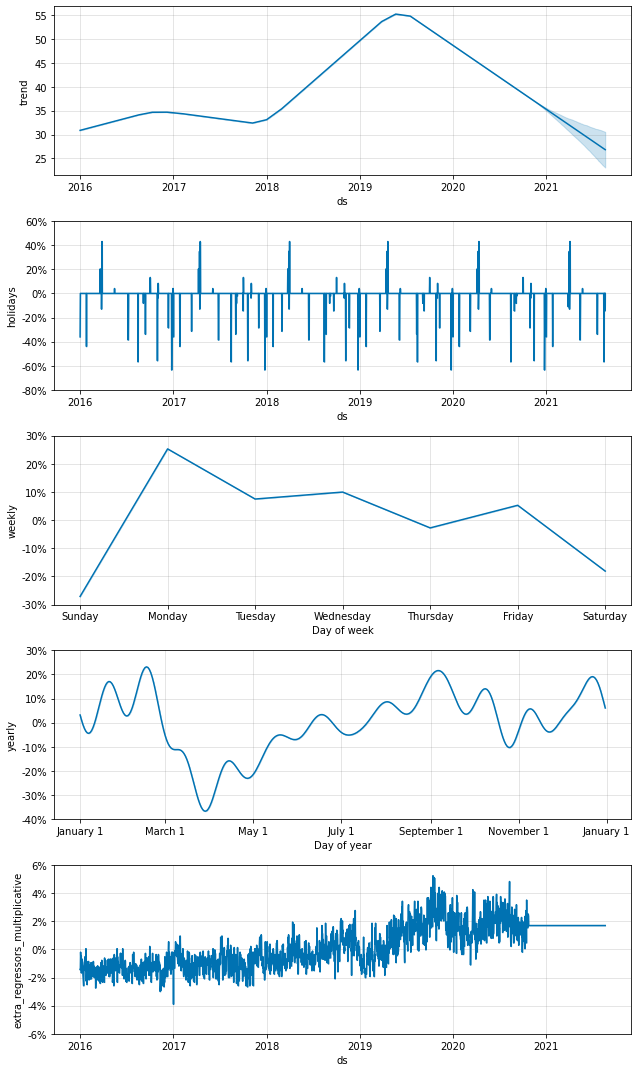

In [215]:
plot_component_negative_articles = m_india_negative_articles.plot_components(forecast_india_negative_articles)


In [216]:
plot_components_plotly(m_india_negative_articles, forecast_india_negative_articles)

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



## Evaluation

In [217]:
demonstrations_eval = pd.concat([forecast_india['yhat'], forecast_india_sentiment_index['yhat'], forecast_india_negative_articles['yhat'], forecast_india['ds']], axis = 1)
demonstrations_eval = pd.merge( demonstrations_eval,india_demonstration_count, left_on = 'ds', right_index= True)
demonstrations_eval.index = demonstrations_eval['ds']
demonstrations_eval = demonstrations_eval.drop(columns = ['ds_x','ds_y', 'ds'])
demonstrations_eval.columns = ['base','sentiment index', 'negative articles', 'truth']
demonstrations_eval

base  sentiment index  negative articles  truth
ds                                                              
2016-01-01  22.479373        22.641559          22.441984   15.0
2016-01-02  26.765623        25.372604          25.665218   21.0
2016-01-03  23.428809        22.934407          22.624930   17.0
2016-01-04  40.035173        40.302085          38.131666   29.0
2016-01-05  33.373597        33.537495          32.259690   33.0
...               ...              ...                ...    ...
2020-10-20  40.394686        39.025828          39.633465   48.0
2020-10-21  40.464050        38.977005          39.895869   41.0
2020-10-22  35.129820        34.671681          34.760641   24.0
2020-10-23  38.171121        37.887739          37.259989   26.0
2020-10-24  28.359822        27.815658          27.837807   11.0

[1759 rows x 4 columns]

In [218]:
demonstrations_eval = demonstrations_eval.fillna(method = 'ffill')

In [219]:
print(f"With holidays:\t{mean_absolute_error(demonstrations_eval['truth'], demonstrations_eval['base']):.4f}")


With holidays:	12.7377


MAE Comparison
MAE of Prophet:	12.7377
MAE with sentiment index:	12.6741
MAE with no. of negative articles:	12.6969


<AxesSubplot:title={'center':'Additional Regressor Evaluation'}, xlabel='ds'>

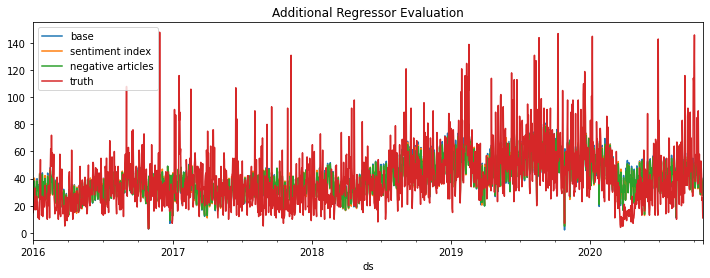

In [232]:
print('MAE Comparison')
print(f"MAE of Prophet:\t{mean_absolute_error(demonstrations_eval['truth'], demonstrations_eval['base']):.4f}")
print(f"MAE with sentiment index:\t{mean_absolute_error(demonstrations_eval['truth'], demonstrations_eval['sentiment index']):.4f}")
print(f"MAE with no. of negative articles:\t{mean_absolute_error(demonstrations_eval['truth'], demonstrations_eval['negative articles']):.4f}")

demonstrations_eval.plot(title='Additional Regressor Evaluation', figsize=(12,4))

RMSE Comparison
RMSE of Prophet:	17.5292
RMSE with sentiment index:	17.5234
RMSE with no. of negative articles:	17.5511


<AxesSubplot:title={'center':'Additional Regressor Evaluation'}, xlabel='ds'>

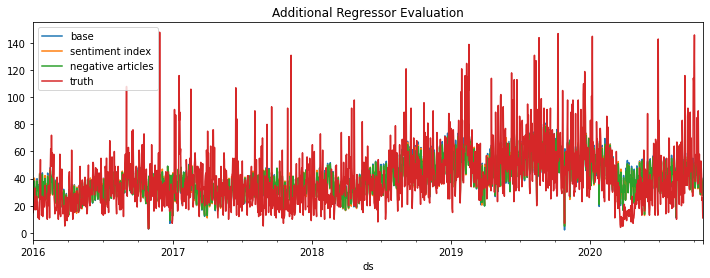

In [231]:
print('RMSE Comparison')
print(f"RMSE of Prophet:\t{mean_squared_error(demonstrations_eval['truth'], demonstrations_eval['base'], squared=False):.4f}")
print(f"RMSE with sentiment index:\t{mean_squared_error(demonstrations_eval['truth'], demonstrations_eval['sentiment index'], squared=False):.4f}")
print(f"RMSE with no. of negative articles:\t{mean_squared_error(demonstrations_eval['truth'], demonstrations_eval['negative articles'], squared=False):.4f}")

demonstrations_eval.plot(title='Additional Regressor Evaluation', figsize=(12,4))

In [223]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='1000 days', period='180 days', horizon = '365 days')

In [228]:
getPerfomanceMetrics(m_india).mean()

INFO:prophet:Making 3 forecasts with cutoffs between 2018-10-30 00:00:00 and 2019-10-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -10.2655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1877.55     0.0386667       92.8864      0.2686           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1881.49   0.000312914       65.3261      0.0481           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        1881.5   0.000140739       58.4093   2.154e-06       0.001      309  LS failed, Hessian reset 
     293       1882.09    0.00137471       68.9676   2.371e-05       0.001      466  LS failed, Hessian reset 
     299       1882.16    0.00143537       79.2649           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1882.46   9.07008e-05       74.1783     0.03272           1      603   
    Iter      log pro

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -13.7238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2136.11     0.0367127       226.497           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       2140.01   0.000600339       90.6874   7.997e-06       0.001      278  LS failed, Hessian reset 
     199       2140.11   0.000156933       81.0133        0.35        0.35      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        2140.3   2.85994e-05       63.9397    5.29e-07       0.001      430  LS failed, Hessian reset 
     299       2140.31   3.21993e-06       67.5128      0.4381      0.4381      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       2140.33   0.000178427       87.6249   2.647e-06       0.001      536  LS failed, Hessian rese

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -15.8769
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2364.23     0.0137203       84.9571           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2368.36    0.00202519       82.3161      0.5876      0.5876      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       2368.48   0.000186618       70.0862   2.363e-06       0.001      331  LS failed, Hessian reset 
     290       2368.55   0.000101673       64.3983   1.185e-06       0.001      448  LS failed, Hessian reset 
     299       2368.56   1.23965e-05       64.1743      0.3122      0.3122      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       2368.58   5.79139e-08       53.4505       0.176       0.176      602   
Optimization terminat

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



horizon     200 days 12:00:00
mse                987.874098
rmse                30.857365
mae                 25.249404
mape                 0.872947
mdape                0.435623
smape                0.469702
coverage              0.46178
dtype: object

In [230]:
getPerfomanceMetrics(m_india_sentiment_index).mean()

INFO:prophet:Making 3 forecasts with cutoffs between 2018-10-30 00:00:00 and 2019-10-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -10.3306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1869.12    0.00465192        187.05      0.5686      0.5686      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       1872.34   0.000655958       78.2574   1.236e-05       0.001      267  LS failed, Hessian reset 
     199       1872.39   5.62789e-06       64.3724           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1872.42   9.25361e-05       59.0519   1.508e-06       0.001      383  LS failed, Hessian reset 
     291       1872.43   1.84954e-07       52.4629      0.2818           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -13.9024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2110.37     0.0073003       71.7242           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        2111.6    0.00039555       81.1328   4.013e-06       0.001      226  LS failed, Hessian reset 
     199       2111.71   9.40364e-05       52.4213      0.5166      0.5166      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       2111.84   0.000619317       90.1754    8.75e-06       0.001      400  LS failed, Hessian reset 
     299       2111.93   0.000608759       78.7732      0.3823           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       2111.95   1.69342e-05       67.0061   2.187e-07       0.001      562  LS failed, Hessian rese

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -16.0907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2340.3    0.00355323       91.6883           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2344.36    0.00168501       129.056      0.5489      0.5489      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       2344.76    0.00381041       84.9504   4.634e-05       0.001      290  LS failed, Hessian reset 
     299        2345.3   0.000121626       64.1455      0.7035      0.7035      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       2345.37   0.000260815       67.0446   3.583e-06       0.001      512  LS failed, Hessian reset 
     399       2345.43   0.000378062       82.1395           1           1      589   
    Iter      log pro

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

INFO:prophet:Skipping MAPE because y close to 0


horizon     201 days 00:00:00
mse                969.049617
rmse                30.610736
mae                 24.912172
mdape                0.428548
smape                0.472754
coverage             0.473941
dtype: object

In [227]:
getPerfomanceMetrics(m_india_negative_articles).mean()

INFO:prophet:Making 3 forecasts with cutoffs between 2018-10-30 00:00:00 and 2019-10-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -10.3306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1870.66     0.0589792       316.909           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146        1872.7   0.000360838       81.8666    3.94e-06       0.001      231  LS failed, Hessian reset 
     183       1872.81    0.00139602       105.428   2.019e-05       0.001      337  LS failed, Hessian reset 
     199       1872.85   6.56411e-06       47.5526      0.2147           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1872.86   5.86218e-05       70.6461   8.743e-07       0.001      434  LS failed, Hessian reset 
     299       1873.08    0.00266322       101.091           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -13.9024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2108.38     0.0142382       259.213      0.5306      0.5306      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2112.2    0.00141011        87.198      0.2693           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       2112.59    2.4662e-05       57.7293   3.955e-07       0.001      400  LS failed, Hessian reset 
     299        2112.6   2.93214e-05       80.7053           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2112.71   4.00035e-05       63.7314      0.3815      0.3815      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       2113.12   8.14152e-05    

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



Initial log joint probability = -16.0907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2340.27    0.00535104       60.4135      0.2456           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2343.81   0.000276691       85.5517      0.4084           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2344.71    0.00632701       80.6709           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       2345.12   0.000332009       98.1865   4.076e-06       0.001      501  LS failed, Hessian reset 
     399       2345.24   0.000151851       76.7832      0.3342           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       2345.25   8.86908e-06    

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/home/bash/news_dataset/clavin/lib/python3.8/site-packages/prophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

INFO:prophet:Skipping MAPE because y close to 0


horizon     201 days 00:00:00
mse                 1011.1155
rmse                31.230301
mae                 25.595922
mdape                0.446466
smape                0.481015
coverage             0.465696
dtype: object